In [55]:
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import os
import pandas as pd
from pyoso import Client

load_dotenv()
OSO_API_KEY = os.environ['OSO_API_KEY']
client = Client(api_key=OSO_API_KEY)
stringify = lambda arr: "'" + "','".join(arr) + "'"

In [2]:
DATE = '2025-04-01'

In [3]:
INCREMENTAL_MODEL_KEYWORDS = {
    'int_events__%': 'time',
    'int_events_daily__%': 'bucket_day',
    'stg_github__events': 'created_at',
    'stg_superchain__%': 'block_timestamp',
    'stg_worldchain__%': 'block_timestamp'
}
like_clauses = [f"(model_name LIKE '{k}')" for k in INCREMENTAL_MODEL_KEYWORDS.keys()]
df_models = client.to_pandas(f"""
   SELECT
     model_name,
     rendered_at
   FROM models_v0
   WHERE rendered_at > DATE('{DATE}') AND ({' OR '.join(like_clauses)})
""")
df_models

,model_name,rendered_at
0,int_events_daily__dependencies,2025-04-01 00:08:24.832
1,int_events__dependencies,2025-04-01 00:08:29.007
2,stg_superchain__4337_traces,2025-05-01 00:13:35.430
3,stg_superchain__4337_userop_logs,2025-05-01 00:13:36.120
4,int_events_weekly__github,2025-05-01 00:14:02.716
5,int_events__4337,2025-05-01 00:13:58.464
6,stg_superchain__deployers,2025-05-01 00:13:37.682
7,int_events_daily_to_project__defillama_tvl,2025-05-01 00:14:05.706
8,stg_worldchain__verified_users,2025-05-01 00:13:35.774
9,int_events_daily__4337,2025-05-01 00:14:02.361


In [5]:
i = 0
results = []
for model_keyword, date_col in INCREMENTAL_MODEL_KEYWORDS.items():
    if '%' in model_keyword:
        model_keyword = model_keyword[:-1]
    model_list = df_models[df_models['model_name'].str.startswith(model_keyword)]['model_name'].unique()
    for model in model_list:
        print(i, model, date_col)
        i += 1
        try:
            result = client.to_pandas(f"""
                SELECT
                  DATE({date_col}) AS bucket_day,
                  COUNT(*) as {model}
                FROM {model}
                WHERE {date_col} >= DATE('{DATE}')
                GROUP BY 1
                ORDER BY 1
            """)
            result.set_index('bucket_day', inplace=True)
            results.append(result)
            print(f"Found {len(result)} dates.")
        except Exception as e:
            print(e)
        print()

0 int_events__dependencies time
400 Client Error: Bad Request for url: https://www.opensource.observer/api/v1/sql - TABLE_NOT_FOUND: line 5:22: Table 'iceberg.oso.int_events__dependencies' does not exist

1 int_events__4337 time
Found 19 dates.

2 int_events__github time
Found 35 dates.

3 int_events__funding time
Found 3 dates.

4 int_events__blockchain time
Found 35 dates.

5 int_events_daily__dependencies bucket_day
400 Client Error: Bad Request for url: https://www.opensource.observer/api/v1/sql - TABLE_NOT_FOUND: line 5:22: Table 'iceberg.oso.int_events_daily__dependencies' does not exist

6 int_events_daily__4337 bucket_day
Found 19 dates.

7 int_events_daily__defillama_tvl bucket_day
Found 31 dates.

8 int_events_daily__funding bucket_day
Found 3 dates.

9 int_events_daily__github bucket_day
Found 35 dates.

10 int_events_daily__blockchain bucket_day
Found 35 dates.

11 int_events_daily__github_with_lag bucket_day
Found 35 dates.

12 stg_github__events created_at
Found 35 dates.

<Axes: >

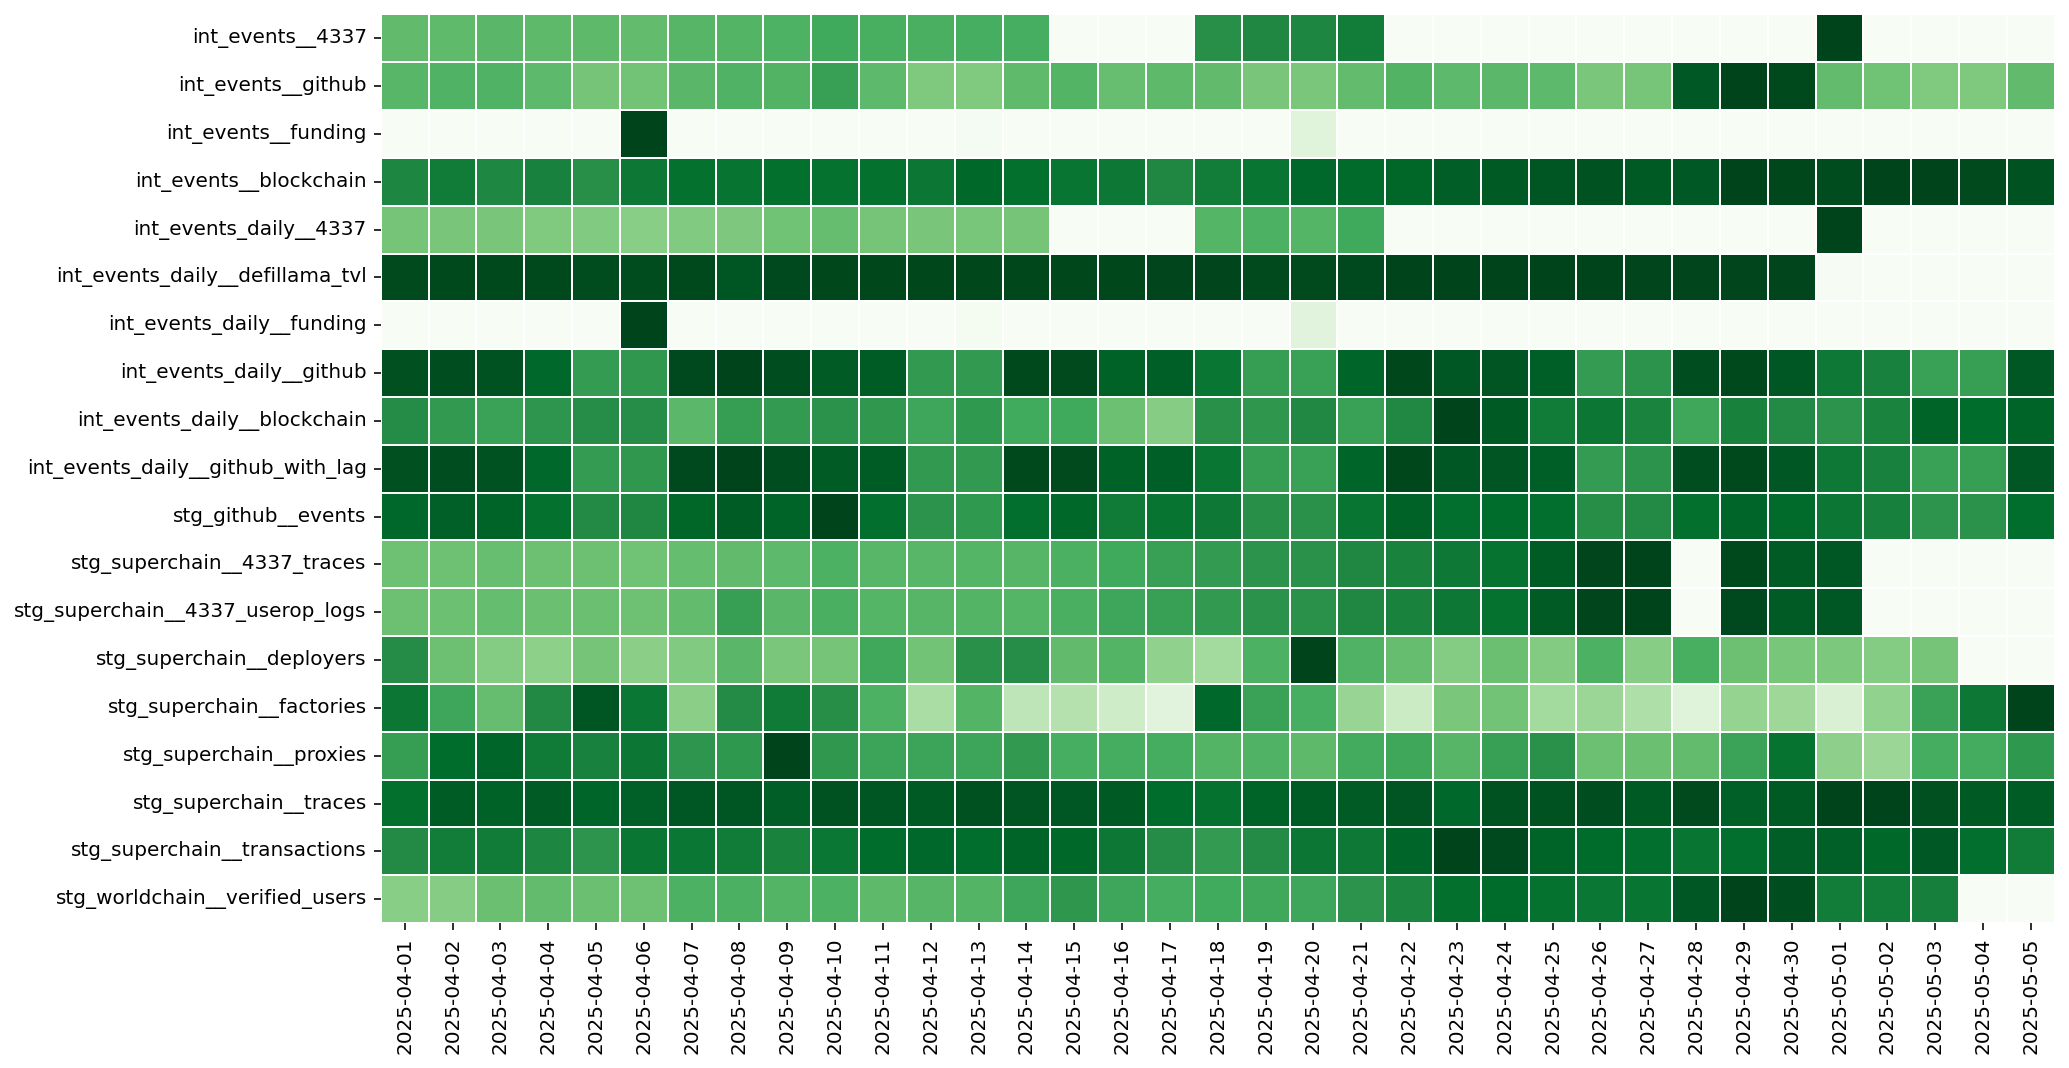

In [57]:
normalized_results = [r / r.max() for r in results]
df_hm = pd.concat(normalized_results, axis=1).fillna(0)
df_hm = df_hm.map(pd.to_numeric)
df_hm.sort_index(inplace=True)
df_hm.index = [f'{d}' for d in df_hm.index]

fig, ax = plt.subplots(figsize=(15,15), dpi=144)
sns.heatmap(df_hm.T, cmap='Greens', square=True, lw=1, cbar=False, ax=ax)